In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc # Garbage Collection module to manage memory

In [ ]:
# Define file paths
data_path = '../data/'

print("Loading data...")

# Load core tables
orders = pd.read_csv(os.path.join(data_path, 'orders.csv'))
op_prior = pd.read_csv(os.path.join(data_path, 'order_products_prior.csv')) 
products = pd.read_csv(os.path.join(data_path, 'products.csv'))

# Load dimension tables
aisles = pd.read_csv(os.path.join(data_path, 'aisles.csv'))
departments = pd.read_csv(os.path.join(data_path, 'departments.csv'))

print("Initial data loading complete.")

Loading data...
Initial data loading complete.


In [ ]:
#Merging Transaction Data with Product Names ---

# Only need the order_id and product_id from op_prior for mining
# Merge product names (product_name) and category info (department) with prior order items
df_transactions = op_prior[['order_id', 'product_id']].merge(
    products[['product_id', 'product_name', 'department_id']], 
    on='product_id', 
    how='left'
)

# Merge department names
df_transactions = df_transactions.merge(departments[['department_id', 'department']], 
                                        on='department_id', 
                                        how='left')

# Add order information (day/hour) for richer EDA
df_transactions = df_transactions.merge(orders[['order_id', 'user_id', 'order_dow', 'order_hour_of_day']],
                                        on='order_id', 
                                        how='left')

# Clean up memory from the original large tables now that the main DF is created
del op_prior, products, orders, aisles, departments
gc.collect()

print(f"Combined data shape: {df_transactions.shape} ({df_transactions.memory_usage(deep=True).sum() / 1024**2:.2f} MB)")

Combined data shape: (32434489, 8) (5540.64 MB)


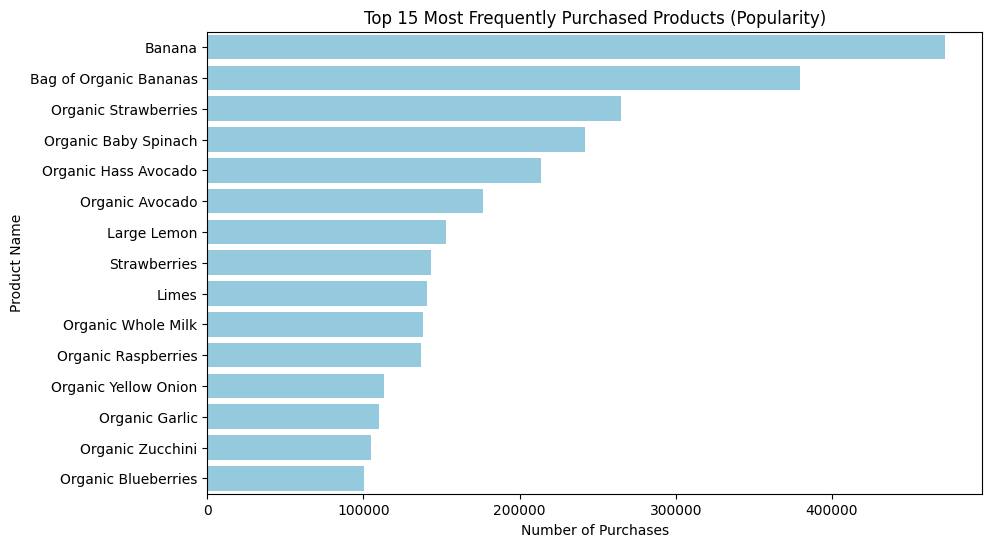

In [4]:
plt.figure(figsize=(10, 6))
top_products = df_transactions['product_name'].value_counts().nlargest(15)
sns.barplot(x=top_products.values, y=top_products.index, color='skyblue')
plt.title('Top 15 Most Frequently Purchased Products (Popularity)')
plt.xlabel('Number of Purchases')
plt.ylabel('Product Name')
plt.savefig('../outputs/images/top_products.png')
plt.show()

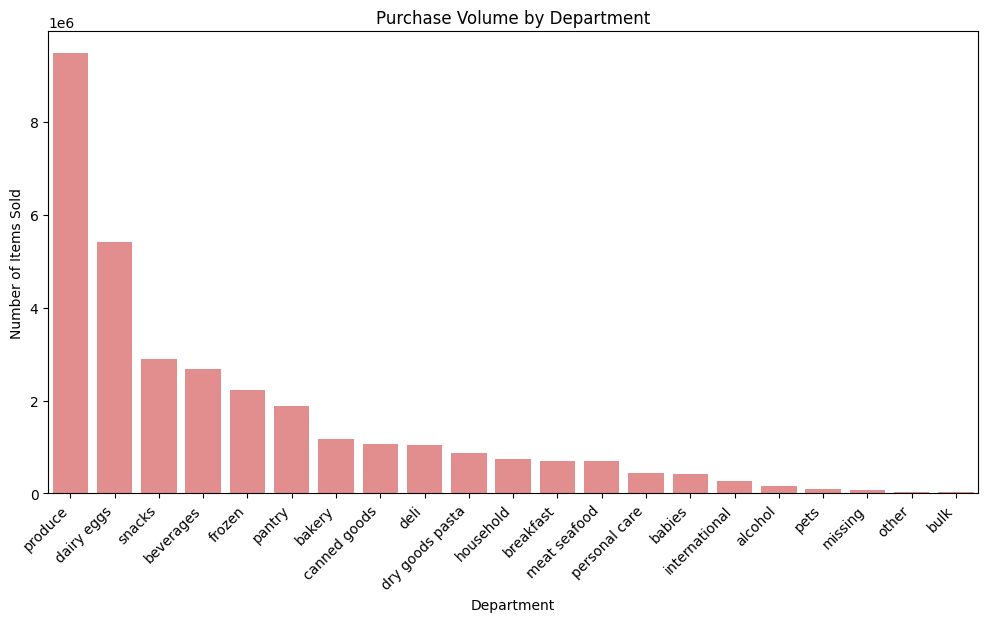

In [5]:
plt.figure(figsize=(12, 6))
top_departments = df_transactions['department'].value_counts()
sns.barplot(x=top_departments.index, y=top_departments.values, color='lightcoral')
plt.title('Purchase Volume by Department')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Department')
plt.ylabel('Number of Items Sold')
plt.savefig('../outputs/images/department_volume.png')
plt.show()

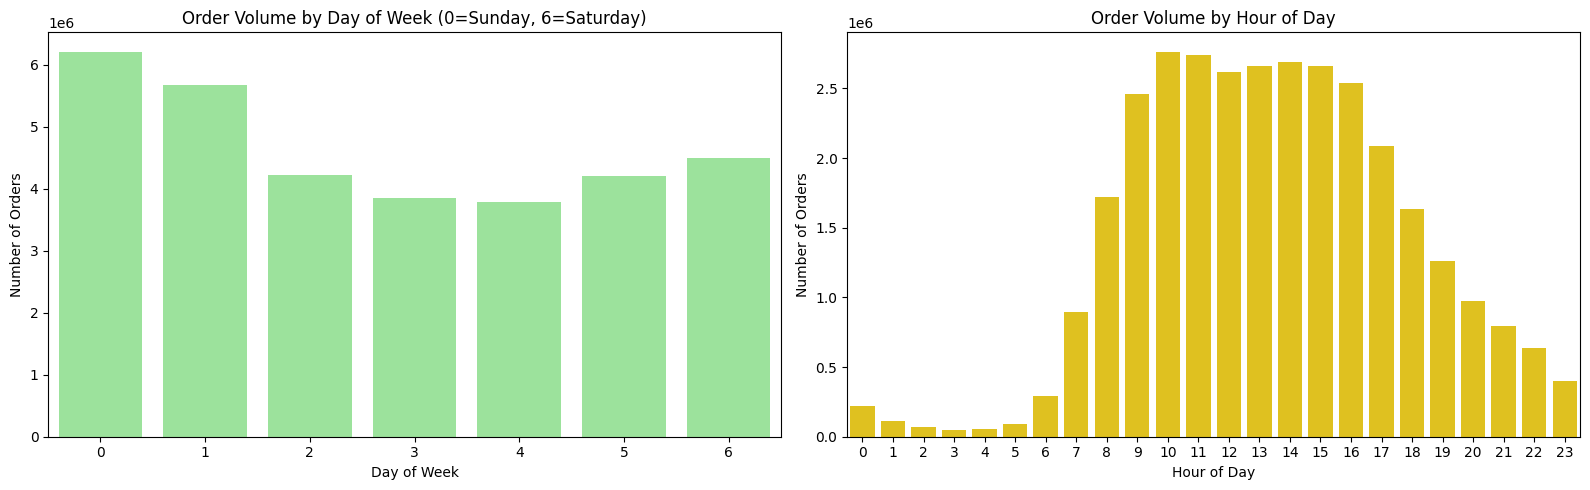

11894

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# By Day of Week (0 is Sunday, 6 is Saturday)
sns.countplot(x='order_dow', data=df_transactions, ax=axes[0], color='lightgreen')
axes[0].set_title('Order Volume by Day of Week (0=Sunday, 6=Saturday)')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Number of Orders')

# By Hour of Day
sns.countplot(x='order_hour_of_day', data=df_transactions, ax=axes[1], color='gold')
axes[1].set_title('Order Volume by Hour of Day')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Number of Orders')

plt.tight_layout()
plt.savefig('../outputs/images/order_timing.png')
plt.show()

# Clean up memory after large analysis
del fig, axes, top_products, top_departments
gc.collect()

In [ ]:
# Identify High-Frequency Items (Aggressive Pruning) ---
# We will focus on products that contribute to the top 75% of total purchases.
product_counts = df_transactions['product_name'].value_counts()
cumulative_percentage = product_counts.cumsum() / product_counts.sum()

# Identify the index where cumulative purchases reach 75%
cutoff_index = cumulative_percentage[cumulative_percentage <= 0.75].index.max()

if cutoff_index is None or len(product_counts[:product_counts.index.get_loc(cutoff_index)+1]) < 500:
    # Fallback to ensure we have a reasonable number of products
    top_products_to_keep = product_counts.head(1500).index
else:
    top_products_to_keep = product_counts[:product_counts.index.get_loc(cutoff_index)+1].index

print(f"Original unique products: {df_transactions['product_name'].nunique()}")
print(f"Products to keep (Top ~{len(top_products_to_keep)}): {len(top_products_to_keep)}")


Original unique products: 49677
Products to keep (Top ~1302): 1302


In [ ]:
# Filter the Transactions ---
df_filtered = df_transactions[df_transactions['product_name'].isin(top_products_to_keep)]
print(f"Filtered data shape (ready for mining): {df_filtered.shape}")

# Implement Sampling ---
# We will sample 10% of users. This dramatically reduces the transaction count.
SAMPLE_FRACTION = 0.10 # Sample 10% of unique users

unique_users = df_filtered['user_id'].unique()
# Randomly select 10% of user IDs
sampled_users = np.random.choice(unique_users, 
                                 size=int(len(unique_users) * SAMPLE_FRACTION), 
                                 replace=False)

# Filter the transactions to include only the sampled users
df_sampled = df_filtered[df_filtered['user_id'].isin(sampled_users)]

# Clean up memory
del df_filtered, df_transactions
gc.collect()

print(f"\nSampling Complete:")
print(f"  Users retained: {len(sampled_users)}")
print(f"  Sampled data shape: {df_sampled.shape}")
print(f"  Expected time savings: Massive.")


# Convert to Transaction Format (List of Lists) ---
# Use the new df_sampled DataFrame
transaction_list = df_sampled.groupby('order_id')['product_name'].apply(list).tolist()

print(f"Total baskets (transactions) for analysis: {len(transaction_list)}")

# Save Processed Data for Next Notebook ---
# Save the new, smaller list of transactions
import pickle
with open('../outputs/clean_transactions.pkl', 'wb') as f:
    pickle.dump(transaction_list, f)
    
print("Saved **sampled** clean_transactions.pkl to the outputs folder.")

Filtered data shape (ready for mining): (18973376, 8)

Sampling Complete:
  Users retained: 20508
  Sampled data shape: (1855883, 8)
  Expected time savings: Massive.
Total baskets (transactions) for analysis: 297322
Saved **sampled** clean_transactions.pkl to the outputs folder.
